# Предсказание оттока пользователей телекоммуникационной компании

Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы.

Данные: [train.csv](https://drive.google.com/file/d/1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K/view?usp=share_link),
[test.csv](https://drive.google.com/file/d/1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r/view?usp=share_link), [submission.csv](https://drive.google.com/file/d/199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y/view?usp=share_link) (как пример посылки)

Если ссылки на данные не работают, их можно скачать [на Kaggle](https://www.kaggle.com/competitions/advanced-dls-spring-2021/data).

# Метрика

В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить, используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она работает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров другого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [3]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных

Проверим, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, заменим их на что-то.

In [5]:
!pip install gdown
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Downloading...
From: https://drive.google.com/uc?id=1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K
To: /Users/katedankova/Study/dls/ user_outflow/train.csv
100%|████████████████████████████████████████| 664k/664k [00:00<00:00, 7.74MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r
To: /Users/katedankova/Study/dls/ user_outflow/test.csv
100%|████████████████████████████████████████| 218k/218k [00:00<00:00, 7.55MB/s]
Downloading...
From: https://drive.google.com/uc?id=199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y
To: /Users/katedankova/Study/dls/ user_outflow/submission.csv
100%|██████████████████████████████████████| 14.7k/14.7k [00:00<00:00, 21.5MB/s]


In [6]:
data = pd.read_csv('./train.csv')
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [7]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [8]:
# Преобразуем значения в столбце TotalSpent в числовой формат
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')

# Проверяем наличие незаполненных значений (NaN) и заменяем их при необходимости
nan_counts_table = pd.DataFrame({'Количество NaN': data.isna().sum()})
print("Количество NaN перед заменой:", nan_counts_table)

null_counts_table = pd.DataFrame({'Количество Null': data.isnull().sum()})
print("Количество Null перед заменой:", null_counts_table)

# Вычисляем медиану столбца TotalSpent
median_total_spent = data['TotalSpent'].median()

# Заменяем отсутствующие значения на медианное значение
data['TotalSpent'] = data['TotalSpent'].fillna(median_total_spent)

# Проверяем, что больше нет отсутствующих значений
print("Количество отсутствующих значений в столбце TotalSpent после замены:", data['TotalSpent'].isnull().sum())

Количество NaN перед заменой:                           Количество NaN
ClientPeriod                           0
MonthlySpending                        0
TotalSpent                             9
Sex                                    0
IsSeniorCitizen                        0
HasPartner                             0
HasChild                               0
HasPhoneService                        0
HasMultiplePhoneNumbers                0
HasInternetService                     0
HasOnlineSecurityService               0
HasOnlineBackup                        0
HasDeviceProtection                    0
HasTechSupportAccess                   0
HasOnlineTV                            0
HasMovieSubscription                   0
HasContractPhone                       0
IsBillingPaperless                     0
PaymentMethod                          0
Churn                                  0
Количество Null перед заменой:                           Количество Null
ClientPeriod                        

## Анализ данных

1) Для численных призанков строим гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных считаем количество каждого значения для каждого признака. Для каждой колонки делаем *data.value_counts()* и строим bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)*.

2) Проверим, являются ли классы несбалансированными.

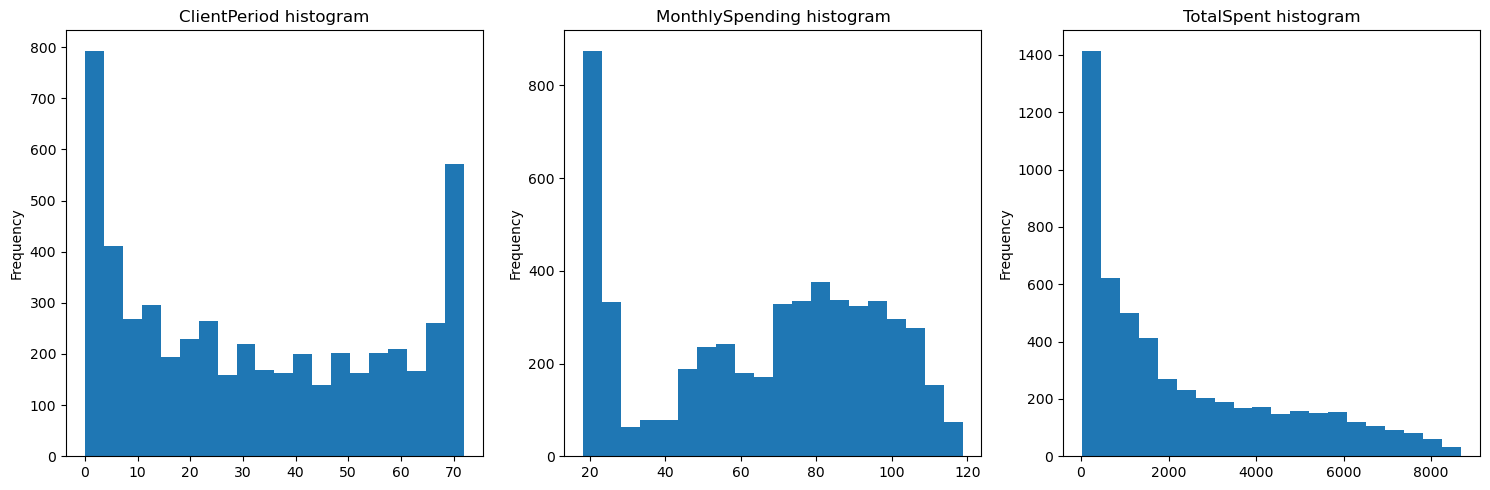

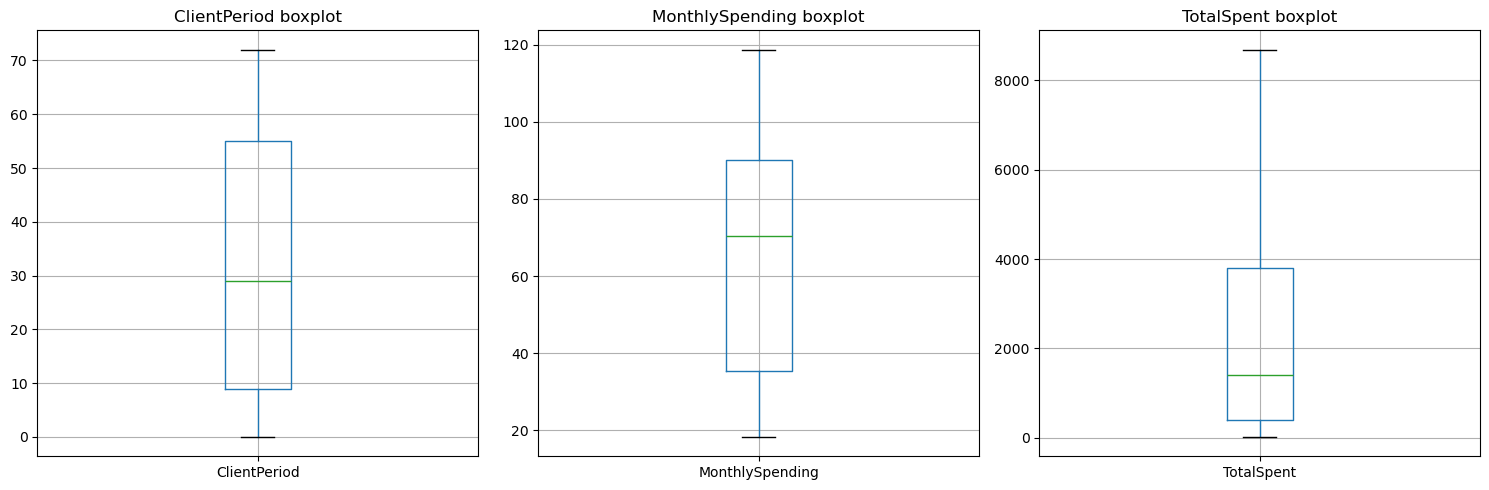

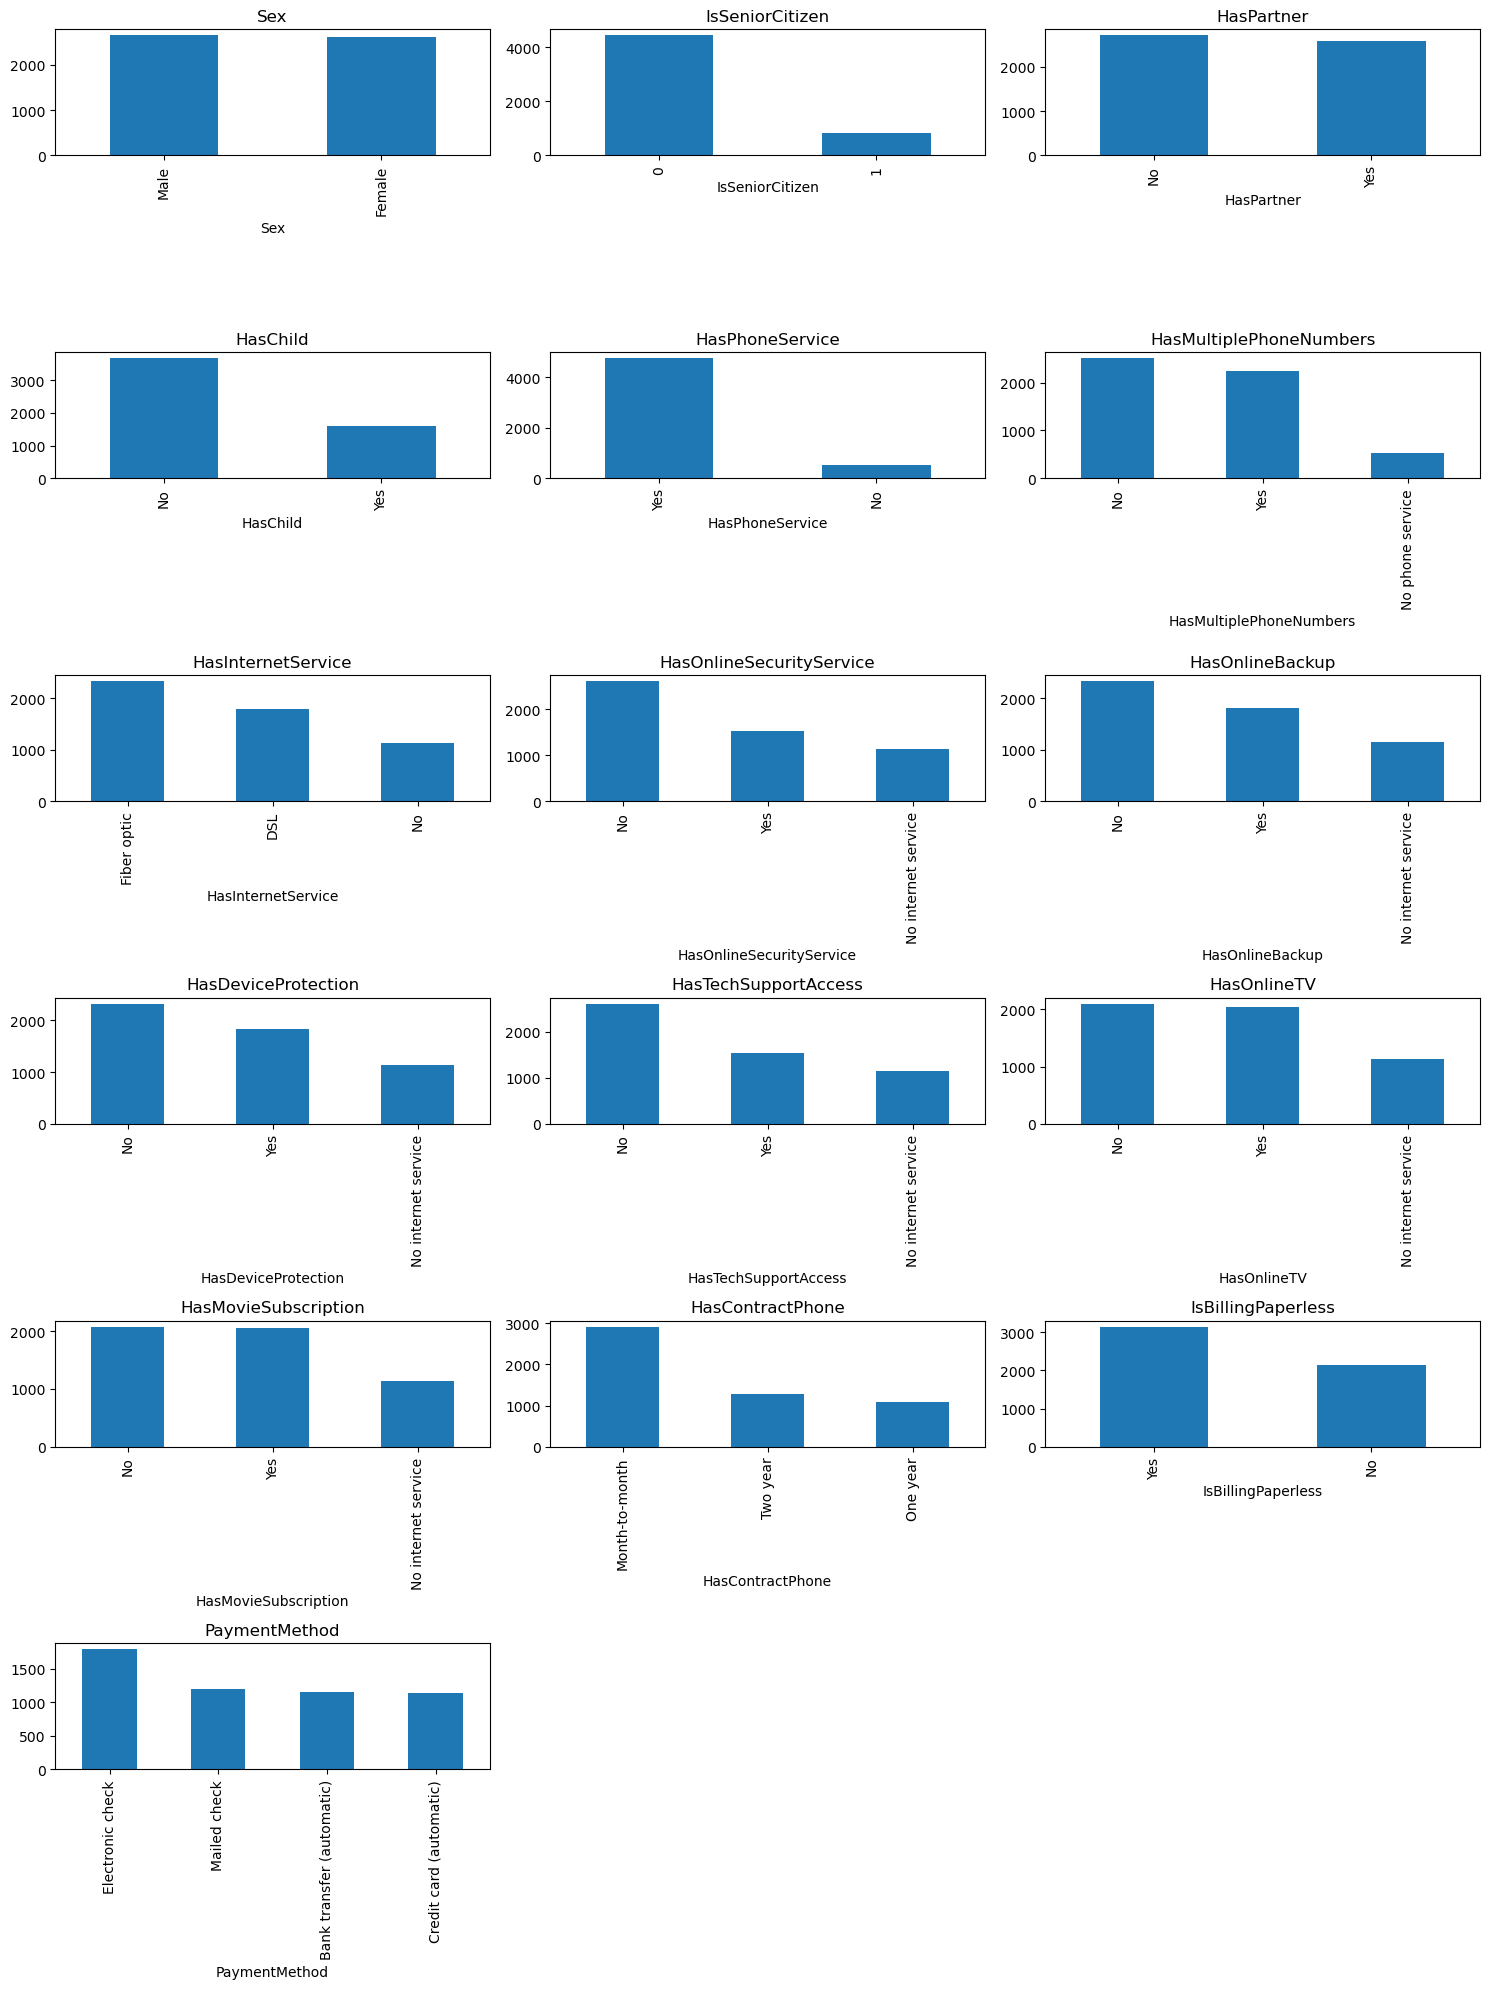

Распределение целевой переменной (Churn):
Churn
0    3898
1    1384
Name: count, dtype: int64
Классы являются несбалансированными.


In [9]:
# Построение гистограмм и boxplot'ов для числовых признаков
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, col in enumerate(num_cols):
    data[col].plot(kind='hist', ax=axes[i], bins=20)
    axes[i].set_title(col + ' histogram')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, col in enumerate(num_cols):
    data.boxplot(column=col, ax=axes[i])
    axes[i].set_title(col + ' boxplot')
plt.tight_layout()
plt.show()

# Подсчёт количества каждого значения для категориальных признаков и построение bar диаграмм
fig, axes = plt.subplots(nrows=len(cat_cols)//3 + 1, ncols=3, figsize=(15, 20))

for i, col in enumerate(cat_cols):
    counts = data[col].value_counts()
    ax = axes[i//3, i%3]
    if len(counts) <= 10:  # Если уникальных значений не слишком много, построим bar диаграмму
        counts.plot(kind='bar', ax=ax)
    else:  # Иначе построим pie диаграмму
        counts.plot(kind='pie', ax=ax)
    ax.set_title(col)

# Уберем пустые и лишние диаграммы
for i in range(len(cat_cols), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

# Посмотрим на распределение целевой переменной (Churn)
churn_counts = data[target_col].value_counts()
print("Распределение целевой переменной (Churn):")
print(churn_counts)

# Проверим, являются ли классы несбалансированными
if churn_counts[0] / churn_counts.sum() > 0.75 or churn_counts[1] / churn_counts.sum() > 0.75:
    print("Классы являются сбалансированными.")
else:
    print("Классы являются несбалансированными.")

## Применение линейных моделей

1) Обработаем данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируем числовые признаки, а категориальные закодируем с помощью one-hot-encoding'а.

2) С помощью кроссвалидации протестируем разные значения гиперпараметра C и выберем лучший по метрике ROC-AUC.

Тк мы не разделяем на train/valid, то используем LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. 

In [10]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score

# Разделение на признаки и целевую переменную
X = data.drop(columns=[target_col])
y = data[target_col]

# Определение категориальных и числовых признаков
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Создание трансформера для нормализации числовых признаков
numeric_transformer = StandardScaler()

# Создание трансформера для кодирования категориальных признаков с помощью OneHotEncoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Соединение трансформеров в один ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

# Создание пайплайна с предобработкой данных и моделью LogisticRegression
pipeline = make_pipeline(preprocessor, LogisticRegression())

# Разделение на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели с кросс-валидацией для подбора гиперпараметра C
param_grid = {'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', refit=True)
grid_search.fit(X_train, y_train)

# Оценка производительности модели на тестовой выборке
y_pred = grid_search.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC на тестовой выборке:", roc_auc)

# Вывод лучшего значения гиперпараметра C
print("Лучшее значение гиперпараметра C:", grid_search.best_params_['logisticregression__C'])

ROC-AUC на тестовой выборке: 0.8273519823422393
Лучшее значение гиперпараметра C: 10


## Применение градиентного бустинга

Часто градиентный бустинг с параметрами по умолчанию даёт 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. Catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделим выборку на train/valid. Протестируем catboost cо стандартными параметрами.

2) Протестируем разные занчения параметров количества деревьев и learning_rate'а и выберем лучшую по метрике ROC-AUC комбинацию.

In [12]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Разделение на признаки и целевую переменную
X = data.drop(columns=[target_col])
y = data[target_col]

# Разделение выборки на обучающую и валидационную
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели CatBoostClassifier с параметрами по умолчанию
model = CatBoostClassifier(cat_features=cat_cols, verbose=0)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

# Предсказание вероятностей для валидационной выборки
y_pred_proba = model.predict_proba(X_valid)[:, 1]

# Вычисление метрики ROC-AUC
roc_auc = roc_auc_score(y_valid, y_pred_proba)
print("ROC-AUC на валидационной выборке с параметрами по умолчанию:", roc_auc)

best_roc_auc = 0
best_params = {}

# Сетка параметров для перебора
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Перебор значений параметров и выбор лучшей комбинации
for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        # Создание и обучение модели с текущими параметрами
        model = CatBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, cat_features=cat_cols, verbose=0)
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
        
        # Предсказание вероятностей для валидационной выборки
        y_pred_proba = model.predict_proba(X_valid)[:, 1]
        
        # Вычисление метрики ROC-AUC
        roc_auc = roc_auc_score(y_valid, y_pred_proba)
        
        # Сохранение лучшей комбинации параметров
        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
            best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

print("Лучшая комбинация параметров:", best_params)
print("ROC-AUC на валидационной выборке с лучшими параметрами:", best_roc_auc)


ROC-AUC на валидационной выборке с параметрами по умолчанию: 0.8307667088408861
Лучшая комбинация параметров: {'n_estimators': 200, 'learning_rate': 0.05}
ROC-AUC на валидационной выборке с лучшими параметрами: 0.8306189451519657


# Предсказания

In [13]:
import pickle

best_model = CatBoostClassifier(n_estimators=200, learning_rate=0.05, cat_features=cat_cols)
best_model.fit(X_train, y_train)

# Save the model using pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

0:	learn: 0.6591832	total: 6.58ms	remaining: 1.31s
1:	learn: 0.6297500	total: 14.9ms	remaining: 1.48s
2:	learn: 0.6032449	total: 20.8ms	remaining: 1.36s
3:	learn: 0.5828272	total: 24.4ms	remaining: 1.2s
4:	learn: 0.5650148	total: 29.1ms	remaining: 1.13s
5:	learn: 0.5504336	total: 31.9ms	remaining: 1.03s
6:	learn: 0.5353156	total: 37.2ms	remaining: 1.03s
7:	learn: 0.5221389	total: 41.6ms	remaining: 999ms
8:	learn: 0.5108989	total: 46.1ms	remaining: 979ms
9:	learn: 0.5021552	total: 52.2ms	remaining: 991ms
10:	learn: 0.4910532	total: 57.7ms	remaining: 991ms
11:	learn: 0.4829618	total: 61.5ms	remaining: 963ms
12:	learn: 0.4746067	total: 66.5ms	remaining: 957ms
13:	learn: 0.4680343	total: 73.1ms	remaining: 971ms
14:	learn: 0.4621888	total: 76.9ms	remaining: 948ms
15:	learn: 0.4569275	total: 81.9ms	remaining: 942ms
16:	learn: 0.4527937	total: 86.9ms	remaining: 935ms
17:	learn: 0.4489486	total: 90.2ms	remaining: 912ms
18:	learn: 0.4454222	total: 94.4ms	remaining: 899ms
19:	learn: 0.4410092	to

In [14]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

# Предсказание вероятности класса 1 для тестовых данных с помощью лучшей модели
submission['Churn'] = best_model.predict_proba(X_test)[:, 1]

# Сохранение результатов в файл
submission.to_csv('./my_submission.csv', index=False)